In [192]:
import requests
import polyline
import math
import random

import pandas as pd
import matplotlib.pyplot as plt
import contextily as ctx

from geopy.distance import distance
from geopy.point import Point

from rdp import rdp

In [193]:
def get_original(coords):
    lat, lon = coords
    return f"{lon},{lat}"

In [203]:
def plot_gpx(df):
    plt.figure(figsize=(10, 10))
    plt.plot(df['longitude'], df['latitude'], color='red', label='Route')
    ctx.add_basemap(plt.gca(), crs='EPSG:4326', source=ctx.providers.OpenStreetMap.Mapnik)
    plt.legend()
    plt.xticks([], [])
    plt.yticks([], [])
    plt.tick_params(axis='both', which='both', bottom=False, top=False, left=False, right=False)
    plt.show()

In [204]:
# We want to make sure that circle is passing through the start point.
# To achive that we pick a center point a given distance away from start point.
# Since we pick a random direction, this gives us a unique circle each time.
def get_center_point(start_coords, distance_km):
    (lat, lon) = start_coords
    
    # Generate a random bearing (direction) in degrees
    bearing = random.uniform(0, 360)

    # Create a Point object for the original latitude and longitude
    original_point = Point(lat, lon)

    # Use the geopy distance module to calculate the new point
    new_point = distance(kilometers=distance_km).destination(original_point, bearing)

    return (new_point.latitude, new_point.longitude)

In [205]:
def get_points_on_circle(center_coords, radius_km, num_points):
    (lat, lon) = center_coords
    center_point = Point(lat, lon)
    
    points = []

    # Calculate the angular interval
    angle_interval = 360 / num_points

    for i in range(num_points):
        angle = angle_interval * i
        point = distance(kilometers=radius_km).destination(point=center_point, bearing=angle)
        points.append((point.latitude, point.longitude))

    return points

In [241]:
def get_route(points):
    points = ';'.join(map(get_original, points))
    params = {
        'geometries': 'polyline6',
    }
    response = requests.get(f"http://127.0.0.1:6000/route/v1/foot/{points}", params=params)
    response.raise_for_status()
    routes = response.json()
    route = polyline.decode(routes['routes'][0]['geometry'], 6)
    return pd.DataFrame(route, columns=['latitude', 'longitude'])

In [242]:
def get_estimated_distance(distance_km):
    return 2 * math.pi * distance_km

In [243]:
start = (1.3096652081895739, 103.8944762995628)
distance_km = 1
number_of_points = 5

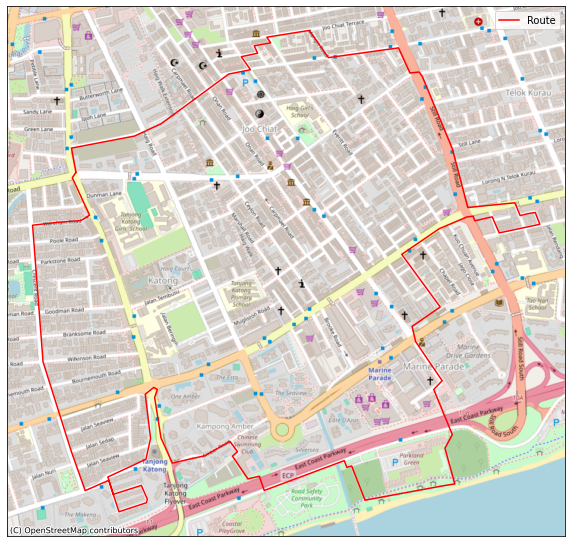

In [244]:
# Center point is not the same as the starting point.
center_point = get_center_point(start, distance_km)

# Pick random points on the circle
points = get_points_on_circle(center_point, distance_km, number_of_points)
# Make sure we start and end at the starting point
points = [(start[0], start[1])] + points + [(start[0], start[1])]

osrm_df = get_route(points)
plot_gpx(osrm_df)

In [245]:
get_distance(osrm_df)

8.97

In [246]:
get_estimated_distance(distance_km)

6.283185307179586

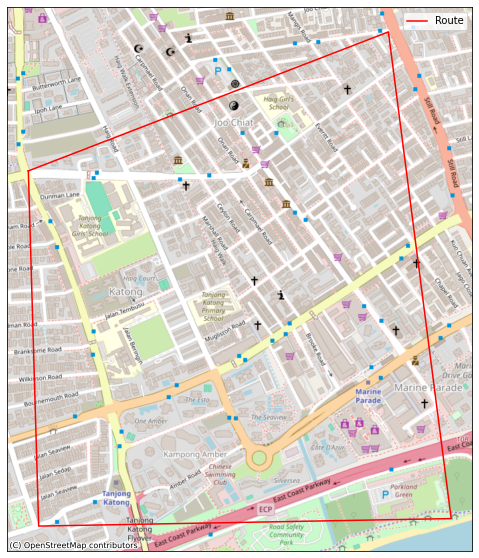

In [247]:
rdp_result = rdp(osrm_df[['latitude', 'longitude']].values, epsilon=0.005)
rdp_df = pd.DataFrame(rdp_result, columns=['latitude', 'longitude'])
plot_gpx(rdp_df)

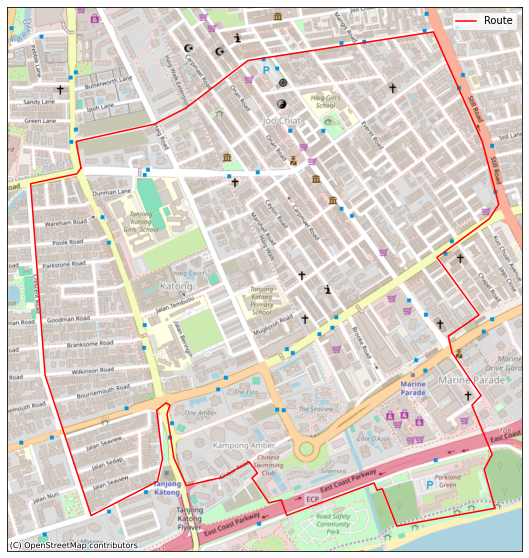

In [248]:
points = list(rdp_df.apply(lambda x: (x['latitude'], x['longitude']), axis=1).to_numpy())
osrm_df = get_route(points)
plot_gpx(osrm_df)